# Imports

First, we'll import the necessary libraries.

In [36]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import datetime
import io
import zipfile
import rasterio
from rasterio.plot import show
import sklearn
from sklearn.neighbors import KernelDensity
import numpy as np
import mapclassify
import collections

# in response to an error importing collections, I used this: https://stackoverflow.com/questions/72032032/importerror-cannot-import-name-iterable-from-collections-in-python

from collections.abc import Iterable

collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

Next, we'll query the City of Philadelphia data via the ArcGIS REST API using the `requests` library. We'll also use the `json` library to parse the response.

Finally, we'll use the `geopandas` library to create a geodataframe from the response.

We have three different datasets to import from the City's ArcGIS server. These are:

### 1. Vacant Land

In [37]:
# Define the URL for the Vacant_Indicators_Land feature service
land_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Land/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Land API request
land_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

# Make the Vacant_Indicators_Land API requests
land_dfs = []
land_offset = 0
while True:
    # Add the offset parameter to the API request
    land_params['resultOffset'] = land_offset
    land_response = requests.get(land_url, params=land_params)
    
    if land_response.status_code == 200:
        # Convert the Vacant_Indicators_Land JSON data to a geopandas geodataframe; convert to CRS 3857
        land_data = land_response.json()

        # convert the JSON data to a pandas dataframe
        land_df = pd.DataFrame(land_data['features'])

        # separate the attributes column into one column per attribute
        land_df = pd.concat([land_df.drop(['attributes'], axis=1), land_df['attributes'].apply(pd.Series)], axis=1)

        # make the `geometry` column a shapely geometry object
        land_df['geometry'] = land_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

        # convert the pandas dataframe to a geopandas geodataframe
        land_gdf = gpd.GeoDataFrame(land_df, geometry='geometry', crs='EPSG:3857')
        land_gdf.to_crs(epsg=2272, inplace=True)

        land_dfs.append(land_gdf)
        land_offset += len(land_gdf)
        
        if len(land_gdf) < 2000:
            break  # If there are fewer than 2000 features returned, it means we have all the data
        
    else:
        print('Vacant_Indicators_Land Request failed with status code:', land_response.status_code)
        break

# Concatenate the dataframes into a single geodataframe
land_gdf = gpd.GeoDataFrame(pd.concat(land_dfs, ignore_index=True), crs='EPSG:2272')


In [38]:
land_gdf.shape

(26249, 14)

### 2. Vacant Buildings

In [39]:
# Define the URL for the Vacant_Indicators_Bldg feature service
bldg_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Bldg/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Bldg API request
bldg_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

# Make the Vacant_Indicators_Bldg API requests
bldg_dfs = []
bldg_offset = 0
while True:
    # Add the offset parameter to the API request
    bldg_params['resultOffset'] = bldg_offset
    bldg_response = requests.get(bldg_url, params=bldg_params)
    
    if bldg_response.status_code == 200:
        # Convert the Vacant_Indicators_bldg JSON data to a geopandas geodataframe; convert to CRS 3857
        bldg_data = bldg_response.json()

        # convert the JSON data to a pandas dataframe
        bldg_df = pd.DataFrame(bldg_data['features'])

        # separate the attributes column into one column per attribute
        bldg_df = pd.concat([bldg_df.drop(['attributes'], axis=1), bldg_df['attributes'].apply(pd.Series)], axis=1)

        # make the `geometry` column a shapely geometry object
        bldg_df['geometry'] = bldg_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

        # convert the pandas dataframe to a geopandas geodataframe
        bldg_gdf = gpd.GeoDataFrame(bldg_df, geometry='geometry', crs='EPSG:3857')
        bldg_gdf.to_crs(epsg=2272, inplace=True)

        bldg_dfs.append(bldg_gdf)
        bldg_offset += len(bldg_gdf)
        
        if len(bldg_gdf) < 2000:
            break  # If there are fewer than 2000 features returned, it means we have all the data
        
    else:
        print('Vacant_Indicators_Bldg Request failed with status code:', bldg_response.status_code)
        break

# Concatenate the dataframes into a single geodataframe
bldg_gdf = gpd.GeoDataFrame(pd.concat(bldg_dfs, ignore_index=True), crs='EPSG:2272')

In [40]:
bldg_gdf.shape

(9771, 14)

### Now, combine the two datasets in preparation for string cleaning.

In [41]:
columns = ['geometry', 'ADDRESS', 'BLDG_DESC',
       'OPA_ID','COUNCILDISTRICT',
       'ZIPCODE','OWNER1', 'OWNER2']

# reduce gdfs to only the columns we want
land_gdf = land_gdf[columns]

bldg_gdf = bldg_gdf[columns]

land_gdf['type'] = 'Lot'

bldg_gdf['type'] = 'Building'

In [42]:
# bind the two geodataframes together using pandas.concat
full_gdf = pd.concat([land_gdf, bldg_gdf], axis=0)

In [43]:
full_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,OWNER1,OWNER2,type
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,NEWCOURTLAND ELDER SVCS,None,Lot
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,REDEVELOPMENT AUTHORITY,OF PHILADELPHIA,Lot
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,REDEVELOPMENT AUTHORITY,OF PHILADELPHIA,Lot
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,MCHUGH JOHN,None,Lot
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,HERBERT MITCHELL,VICTORIA,Lot


### Now we'll apply string cleaning to the OWNER1 and OWNER2 columns to identify public vs. private ownership.

In [44]:
public_owners = ['PHILADELPHIA LAND BANK',
                'PHILADELPHIA HOUSING AUTH',
                'CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA',
                'DEPT OF PUBLC PROP; CITY OF PHILA',
                'DEPT OF PUBLIC PROP; CITY OF PHILA',
                'DEPT PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILA',
                'PHILA REDEVELOPMENT AUTH',
                'PHILADELPHIA LAND INVESTM',
                'REDEVELOPMENT AUTHORITY O',
                'PHILADELPHIA REDEVELOPMEN',
                'PHILA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHOR',
                'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING',
                'PHILA REDEVELOPMENT AUTHO',
                'DEPT OF PUB PROP; CITY OF PHILA',
                'PHILA HOUSING DEV CORP',
                'DEP OF PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY',
                'COMMONWEALTH OF PA',
                'COMMONWEALTH OF PENNA',
                'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                'DEPT PUBLIC PROP R E DIV; CITY OF PHILA',
                'PUBLIC PROP DIV; CITY OF PHILA',
                'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                'REAL ESTATE DIV; CITY OF PHILA',
                'REAL ESTATE DIVISION; CITY OF PHILA',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING'
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA REDEVELOPMENT AUTH',
                'PHILADELPHIA HOUSING AUTHORITY',
                'PHILADELPHIA LAND BANK',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA HOUSING AUTHORITY',
                'CITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHORITY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'COMMONWEALTH OF PENNSYLVANIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PENNDOT'
]

# return unique public_owners
public_owners = list(set(public_owners))

In [45]:
# create a new column that combines the OWNER1 and OWNER2 columns according to the following rules:
# if OWNER1 is not null and OWNER2 is null, then the new column is OWNER1
# if OWNER1 is null and OWNER2 is not null, then the new column is OWNER2
# if OWNER2 starts with a preposition, then the new column is OWNER1 + OWNER2 separated by a space
# if OWNER2 does not start with a preposition, then the new column is OWNER2 + OWNER1 separated by a se


# define a function to check if a string starts with a preposition
def starts_with_preposition(string):
    prepositions = ['a', 'an', 'and', 'as', 'at', 'but', 'by', 'for', 'from', 'in', 'into', 'nor', 'of', 'on', 'or', 'so', 'the', 'to', 'up', 'yet']
    if string.split(' ')[0].lower() in prepositions:
        return True
    else:
        return False
    
# define a function to combine the OWNER1 and OWNER2 columns
def combine_owners(row):
    if pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return None
    elif pd.isnull(row['OWNER1']) and not pd.isnull(row['OWNER2']):
        return row['OWNER2']
    elif not pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return row['OWNER1']
    elif starts_with_preposition(row['OWNER2']):
        return row['OWNER1'] + ' ' + row['OWNER2']
    else:
        return row['OWNER2'] + '; ' + row['OWNER1']
    
# apply the combine_owners function to the full_gdf dataframe
full_gdf['OWNER'] = full_gdf.apply(combine_owners, axis=1)

# if OWNER is 'PHILADELPHIA HOUSING AUTH' or 'PHILA HOUSING AUTHORITY', replace with 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILADELPHIA HOUSING AUTH', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING AUTHORITY', 'OWNER'] = 'PHILADELPHIA HOUSING AUTHORITY'

# redevelopment authority typos
redev_owner_variations = ['REDEVELOPMENT AUTHORITY OF PHILA', 'PHILA REDEVELOPMENT AUTH',
'REDEVELOPMENT AUTHORITY O', 'PHILADELPHIA REDEVELOPMEN',
'PHILA REDEVELOPMENT AUTHO', 'REDEVELOPMENT AUTHORITY',
'REDEVELOPMENT AUTH']

for var in redev_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA'

# department of public property typos
dpp_owner_variations = ['DEPT OF PUBLIC PROPERTY', 'DEPT OF PUBLIC PROPERT', 'DEPT OF PUBLC PROP; CITY OF PHILA',
                        'DEPT OF PUBLIC PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROPERTY; CITY OF PHILA', 'DEPT PUB PROP; CITY OF PHILA',
                        'DEPT OF PUB PROP; CITY OF PHILA', 'DEP OF PUB PROP; CITY OF PHILA', 'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                        'DEPT PUBLIC PROP R E DIV; CITY OF PHILA', 'PUBLIC PROP DIV; CITY OF PHILA', 'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                        'REAL ESTATE DIV; CITY OF PHILA', 'REAL ESTATE DIVISION; CITY OF PHILA']

for var in dpp_owner_variations:
    full_gdf.loc[full_gdf['OWNER'] == var, 'OWNER'] = 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY'

# HUD
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'
full_gdf.loc[full_gdf['OWNER'] == 'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND', 'OWNER'] = 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT'

# commonwealth of pennsylvania
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'
full_gdf.loc[full_gdf['OWNER'] == 'COMMONWEALTH OF PENNA', 'OWNER'] = 'COMMONWEALTH OF PENNSYLVANIA'

# phdc
full_gdf.loc[full_gdf['OWNER'] == 'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'
full_gdf.loc[full_gdf['OWNER'] == 'PHILA HOUSING DEV CORP', 'OWNER'] = 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION'

# PennDOT
full_gdf.loc[full_gdf['OWNER'] == 'DEPARTMENT OF TRANSPORTAT; COMMONWEALTH OF PENNSYLVA', 'OWNER'] = 'PENNDOT'

# city of Philadelphia
full_gdf.loc[full_gdf['OWNER'] == 'CITY OF PHILADELPHIA', 'OWNER'] = 'CITY OF PHILA'

# create a new column called 'public_owner' that is True if the OWNER column is in the public_owners list
full_gdf['public_owner'] = full_gdf['OWNER'].isin(public_owners)

# drop the OWNER1 and OWNER2 columns
full_gdf = full_gdf.drop(['OWNER1', 'OWNER2'], axis=1)

In [46]:
# randomly sample ten rows from the full_gdf dataframe
full_gdf.sample(10)

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner
12722,"POLYGON ((2692428.662 253622.496, 2692414.587 ...",2126 W TORONTO ST,VAC LAND RES < ACRE,111098600,8,19132,Lot,ARIEL VIEW CONSTRUCTION & REALTY LLC,False
6906,"POLYGON ((2675009.358 228634.646, 2674963.904 ...",1938 S SALFORD ST,ROW 2 STY MASONRY,401079800,2,19143,Lot,KENAN LLC,False
565,"POLYGON ((2692034.069 249395.734, 2692031.768 ...",2246 N 21ST ST,VAC LAND RES < ACRE,162183400,5,19132,Lot,A TO Z REAL ESTATE TRANSACTION LLC,False
17166,"POLYGON ((2692497.524 269222.354, 2692501.915 ...",5601 MCMAHON AVE,VAC LAND RES < ACRE,122206100,8,19144,Lot,PANELING J H S INC,False
5180,"POLYGON ((2673814.414 235934.859, 2673813.915 ...",5552 ADDISON ST,ROW 2 STY MASONRY,604130700,3,19143,Building,LUBLIN WILLIAM; WALSH JAMES,False
5421,"POLYGON ((2695626.268 260086.547, 2695617.839 ...",1648 DOUNTON ST,ROW 2 STY MASONRY,132293100,8,19140,Building,MILLS BLESSENCE,False
5536,"POLYGON ((2692115.182 250001.412, 2692112.740 ...",2350 N 21ST ST,VAC LAND RES < ACRE,162186901,5,19132,Lot,PHILADELPHIA HOUSING AUTHORITY,True
23185,"POLYGON ((2692342.507 265841.791, 2692358.343 ...",230 E BRINGHURST ST,VAC LAND RES < ACRE,121105605,8,19144,Lot,CMC INVESTMENT GROUP LLC,False
19018,"POLYGON ((2685751.167 229129.934, 2685749.166 ...",1547 S DOVER ST,VAC LAND RES < ACRE,364380715,2,19146,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True
23610,"POLYGON ((2673647.721 264315.247, 2673639.816 ...",128 WRIGHT ST,VAC LAND RES < ACRE,211000038,4,19127,Lot,PENN CENTRAL CORP A PA CORPORATION,False


### 3. PHS LandCare Parcels

Now we can import the PHS Community and Philadelphia LandCare parcels and spatially join them to our full_gdf, which contains all of the vacant parcels in the city (both lots and buildings).

(Note that Community LandCare parcels are taken care of by community groups, while LandCare parcels are taken care of by PHS. There are roughly three times as many Philadelphia LandCare parcels as Community LandCare parcels.)

In [47]:
# Define the URL for the PHS_CommunityLandcare feature service
phs_landcare_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_CommunityLandcare/FeatureServer/0/query'

# Define the parameters for the PHS_CommunityLandcare API request
phs_landcare_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

# Make the PHS_CommunityLandcare API requests
phs_dfs = []
phs_offset = 0
while True:
    # Add the offset parameter to the API request
    phs_landcare_params['resultOffset'] = phs_offset
    phs_landcare_response = requests.get(phs_landcare_url, params=phs_landcare_params)
    
    if phs_landcare_response.status_code == 200:
        # Convert the PHS_CommunityLandcare JSON data to a geopandas geodataframe; convert to CRS 3857
        phs_landcare_data = phs_landcare_response.json()

        # convert the JSON data to a pandas dataframe
        phs_landcare_df = pd.DataFrame(phs_landcare_data['features'])

        # separate the attributes column into one column per attribute
        phs_landcare_df = pd.concat([phs_landcare_df.drop(['attributes'], axis=1), phs_landcare_df['attributes'].apply(pd.Series)], axis=1)

        # make the `geometry` column a shapely geometry object
        phs_landcare_df['geometry'] = phs_landcare_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

        # convert the pandas dataframe to a geopandas geodataframe
        phs_landcare_gdf = gpd.GeoDataFrame(phs_landcare_df, geometry='geometry', crs='EPSG:3857')
        phs_landcare_gdf.to_crs(epsg=2272, inplace=True)

        phs_dfs.append(phs_landcare_gdf)
        phs_offset += len(phs_landcare_gdf)
        
        if len(phs_landcare_gdf) < 2000:
            break  # If there are fewer than 2000 features returned, it means we have all the data
        
    else:
        print('PHS_CommunityLandcare Request failed with status code:', phs_landcare_response.status_code)
        break

# Concatenate the dataframes into a single geodataframe
phs_landcare_gdf = gpd.GeoDataFrame(pd.concat(phs_dfs, ignore_index=True), crs='EPSG:2272')

phs_cols = ['geometry', 'COMM_PARTN']

phs_landcare_gdf = phs_landcare_gdf[phs_cols]

In [48]:
phs_landcare_gdf.shape

(2263, 2)

In [49]:
# Import necessary libraries
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# Define the URL for the PHS_PhilaLandCare_Maintenance feature service
phs_maintenance_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_PhilaLandCare_Maintenance/FeatureServer/0/query'

# Define the parameters for the PHS_PhilaLandCare_Maintenance API request
phs_maintenance_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json',
    'resultRecordCount': 2000 # Number of features to return per request
}

# Make the PHS_PhilaLandCare_Maintenance API requests
phs_maintenance_dfs = []
phs_maintenance_offset = 0
while True:
    # Add the offset parameter to the API request
    phs_maintenance_params['resultOffset'] = phs_maintenance_offset
    phs_maintenance_response = requests.get(phs_maintenance_url, params=phs_maintenance_params)

    if phs_maintenance_response.status_code == 200:
        # Convert the PHS_PhilaLandCare_Maintenance JSON data to a geopandas geodataframe; convert to CRS 2272
        phs_maintenance_data = phs_maintenance_response.json()

        # Convert the JSON data to a pandas dataframe
        phs_maintenance_df = pd.DataFrame(phs_maintenance_data['features'])

        # Separate the attributes column into one column per attribute
        phs_maintenance_df = pd.concat([phs_maintenance_df.drop(['attributes'], axis=1), phs_maintenance_df['attributes'].apply(pd.Series)], axis=1)

        # Make the `geometry` column a shapely geometry object
        phs_maintenance_df['geometry'] = phs_maintenance_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

        # Convert the pandas dataframe to a geopandas geodataframe
        phs_maintenance_gdf = gpd.GeoDataFrame(phs_maintenance_df, geometry='geometry', crs='EPSG:3857')
        phs_maintenance_gdf.to_crs(epsg=2272, inplace=True)

        phs_maintenance_dfs.append(phs_maintenance_gdf)
        phs_maintenance_offset += len(phs_maintenance_gdf)

        if len(phs_maintenance_gdf) < 2000:
            break  # If there are fewer than 2000 features returned, it means we have all the data

    else:
        print('PHS_PhilaLandCare_Maintenance request failed with status code:', phs_maintenance_response.status_code)
        break

# Concatenate the dataframes into a single geodataframe
phs_maintenance_gdf = gpd.GeoDataFrame(pd.concat(phs_maintenance_dfs, ignore_index=True), crs='EPSG:2272')

In [50]:
# add a column called 'COMM_PARTN' to phs_maintenance_gdf
phs_maintenance_gdf['COMM_PARTN'] = 'PHS'

phs_maintenance_gdf.head()

,geometry,OBJECTID,TENCODE,ADDRESS,OWNER1,OWNER2,BLDG_CODE,BLDG_DESC,BRT_ID,GROSS_AREA,...,TARGETAREA,GROUP_,GRID,CCD,CCD_PERSON,ADDR_RANGE,ZIPCODE,Shape__Area,Shape__Length,COMM_PARTN
0,"POLYGON ((38072906.949 9038661.368, 38072735.2...",1,5386002312,2312 N MARSHALL ST,PHILA REDEVELOPMENT AUTH,,SR,VAC LAND RES < ACRE,371049900,1273,...,Eastern North,None,278,5,Darrell L. Clarke,2310-2316 MARSHALL STREET,19133,1279.597046,195.672676,PHS
1,"POLYGON ((38072793.021 9037859.769, 38072982.1...",2,8793002301,2301-03 N 07TH ST,CITY OF PHILA,,SC,VAC LAND COMM. < ACRE,886810561,3067,...,Eastern North,None,278,5,Darrell L. Clarke,2303 N 7TH STREET,19133,3170.937927,245.624697,PHS
2,"POLYGON ((38077466.257 9033586.477, 38077307.4...",3,8795002027,2027 N 08TH ST,COMET HOMES INC,,SR,VAC LAND RES < ACRE,202097400,1147,...,Eastern North,None,278,5,Darrell L. Clarke,2027 N 8TH STREET,19122,1137.090088,179.889029,PHS
3,"POLYGON ((38069053.463 8996069.382, 38069099.6...",4,8834001439,1439 N 28TH ST,HARRISON INC,,SR,VAC LAND RES < ACRE,292094500,999,...,North Central,None,290,5,Darrell L. Clarke,1439-41 N 28TH ST,19121,992.503540,171.520004,PHS
4,"POLYGON ((38082328.371 9033585.867, 38082383.1...",5,5386001825,1825 N MARSHALL ST,CITY OF PHILA,,SR,VAC LAND RES < ACRE,201131201,905,...,Eastern North,None,292,5,Darrell L. Clarke,1821-1827 N MARSHALL STREET,19122,935.317322,148.531771,PHS


In [51]:
phs_maintenance_gdf.shape

(6788, 26)

In [52]:
# Select the columns of interest
phs_maintenance_cols = ['geometry', 'COMM_PARTN']
phs_maintenance_gdf = phs_maintenance_gdf[phs_maintenance_cols]

In [53]:
# append phs_maintenance_gdf and phs_landcare_gdf; call the new gdf phs_gdf
phs_gdf = phs_maintenance_gdf.append(phs_landcare_gdf, ignore_index=True)

C:\Users\Nissim\AppData\Local\Temp\ipykernel_27396\1389667071.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  phs_gdf = phs_maintenance_gdf.append(phs_landcare_gdf, ignore_index=True)


In [54]:
# spatially join phs_landcare_gdf to full_gdf
joined_gdf = gpd.sjoin(full_gdf, phs_gdf, how='left', predicate='intersects')

# drop the index_right column and the ADDRESS_right column
joined_gdf = joined_gdf.drop(['index_right'], axis=1)

joined_gdf['COMM_PARTN'] = joined_gdf['COMM_PARTN'].fillna('None', inplace=True)

In [55]:
joined_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None


In [56]:
# return the number of rows in joined_gdf where COMM_PARTN is not None
len(joined_gdf[joined_gdf['COMM_PARTN'] != 'None'])

36020

In [57]:
# return the first five rows of joined_gdf where COMM_PARTN is not None
joined_gdf[joined_gdf['COMM_PARTN'] != 'None'].head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None


In [58]:
joined_gdf.columns

Index(['geometry', 'ADDRESS', 'BLDG_DESC', 'OPA_ID', 'COUNCILDISTRICT',
       'ZIPCODE', 'type', 'OWNER', 'public_owner', 'COMM_PARTN'],
      dtype='object')

Now we need to import two more datasets from the City's Carto database (SQL).

### 1. L&I Complaints

In [72]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
complaints_sql_query = "SELECT address, service_request_id, subject, status, service_name, service_code, lat, lon FROM public_cases_fc WHERE requested_datetime >= '{}'".format(one_year_ago)

# Make the GET request
complaints_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": complaints_sql_query})

# Get the data
complaints_data = complaints_response.json()["rows"]

# convert complaints_data to a pandas dataframe
complaints_df = pd.DataFrame(complaints_data)

# Convert the data to a geopandas dataframe
complaints_gdf = gpd.GeoDataFrame(complaints_df, geometry=gpd.points_from_xy(complaints_df.lon, complaints_df.lat), crs='EPSG:2272')

<Axes: >

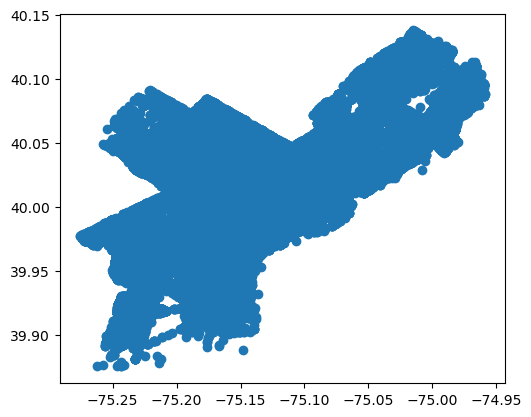

In [73]:
complaints_gdf.plot()

In [59]:
# drop the lat and lon columns
complaints_gdf.drop(['lat', 'lon'], axis=1, inplace=True)

# filter for only Status = 'Open'
complaints_gdf = complaints_gdf[complaints_gdf['status'] == 'Open']

# collapse complaints_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
complaints_gdf = complaints_gdf.groupby('address')['service_name'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_complaints'
complaints_gdf.rename(columns={'service_name': 'li_complaints'}, inplace=True)

In [60]:
complaints_gdf.shape

(40888, 2)

In [69]:
# plot the complaints_gdf
complaints_gdf.plot()

TypeError: no numeric data to plot

In [61]:
complaints_gdf.head(10)

,address,li_complaints
0,(615) 840-0518,Maintenance Complaint
1,1 BLACKWELL PL # 1,Street Trees
2,1 CHRISTIAN ST # 23U,Abandoned Vehicle
3,1 FOUNTAIN GREEN DR,Abandoned Vehicle
4,1 FRANKLIN TOWN BLVD,Maintenance Complaint; Street Trees
5,1 LONGFORD ST,Abandoned Vehicle; Abandoned Vehicle
6,1 N 30TH ST,Manhole Cover
7,1 N KINGS OAK LN,Other (Streets); Street Defect
8,1 QUEEN ST,Graffiti Removal
9,1 RED LION RD,Street Defect; Maintenance Complaint


### 2. L&I Code Violations

In [78]:
# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
violations_sql_query = "SELECT parcel_id_num, casenumber, casecreateddate, casetype, casestatus, violationnumber, violationcodetitle, violationstatus, opa_account_num, address, opa_owner, geocode_x, geocode_y FROM violations WHERE violationdate >= '{}'".format(one_year_ago)

# Make the GET request
violations_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": violations_sql_query})

# Get the data
violations_data = violations_response.json()["rows"]

# convert violations_data to a pandas dataframe
violations_df = pd.DataFrame(violations_data)

# Convert the data to a geopandas dataframe
violations_gdf = gpd.GeoDataFrame(violations_df, geometry=gpd.points_from_xy(violations_df.geocode_x, violations_df.geocode_y), crs='EPSG:2272')

<Axes: >

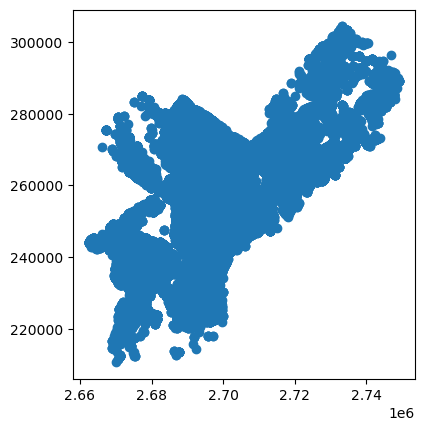

In [75]:
violations_gdf.plot()

In [87]:
all_violations_count_df = violations_gdf.groupby('opa_account_num').count().reset_index()[['opa_account_num', 'violationnumber']]
all_violations_count_df = all_violations_count_df.rename(columns={'violationnumber': 'all_violations_past_year'})

In [88]:
all_violations_count_df.head(10)

,opa_account_num,all_violations_past_year
0,011020300,3
1,011026000,1
2,011075500,3
3,011075600,3
4,011079900,2
5,011082200,1
6,011084500,8
7,011088800,1
8,011089700,1
9,011091900,3


In [89]:
# drop the lat and lon columns
#violations_gdf.drop(['geocode_x', 'geocode_y'], axis=1, inplace=True)

# filter for only cases where the casestatus is 'IN VIOLATION' or 'UNDER INVESTIGATION'
violations_gdf = violations_gdf[(violations_gdf['violationstatus'] == 'OPEN')]

open_violations_count_df = violations_gdf.groupby('opa_account_num').count().reset_index()[['opa_account_num', 'violationnumber']]
open_violations_count_df = open_violations_count_df.rename(columns={'violationnumber': 'open_violations_past_year'})

In [90]:
open_violations_count_df.head(10)

,opa_account_num,open_violations_past_year
0,011020300,3
1,011075600,2
2,011079900,2
3,011082200,1
4,011108600,3
5,011118600,11
6,011138600,1
7,011149300,1
8,011151200,5
9,011231200,3


In [96]:
# join the all_violations_count_df and open_violations_count_df dataframes on opa_account_num
violations_count_gdf = all_violations_count_df.merge(open_violations_count_df, how='left', on='opa_account_num')

# replace NaN values with 0
violations_count_gdf.fillna(0, inplace=True)

# convert the all_violations_past_year and open_violations_past_year columns to integers
violations_count_gdf['all_violations_past_year'] = violations_count_gdf['all_violations_past_year'].astype(int)
violations_count_gdf['open_violations_past_year'] = violations_count_gdf['open_violations_past_year'].astype(int)

In [97]:
violations_count_gdf.head(10)

,opa_account_num,all_violations_past_year,open_violations_past_year
0,011020300,3,3
1,011026000,1,0
2,011075500,3,0
3,011075600,3,2
4,011079900,2,2
5,011082200,1,1
6,011084500,8,0
7,011088800,1,0
8,011089700,1,0
9,011091900,3,0


In [76]:

# collapse violations_gdf by address and concatenate the violationcodetitle values into a list with a semicolon separator
violations_gdf = violations_gdf.groupby('opa_account_num')['violationcodetitle'].apply(lambda x: '; '.join([val for val in x if val is not None])).reset_index()

# rename the column to 'li_violations'
violations_gdf.rename(columns={'violationcodetitle': 'li_code_violations'}, inplace=True)

In [77]:
violations_gdf.plot()

TypeError: no numeric data to plot

In [63]:
violations_gdf.shape

(12356, 2)

In [64]:
violations_gdf.head(10)

,opa_account_num,li_code_violations
0,011020300,UNSAFE STRUCTURE; EXTERIOR WALLS; ARCHITECT/EN...
1,011075600,NEW STRUCTURE; ARCHITECT/ENGINEER SERVICES
2,011079900,ZONING AND USE REGISTRATION PERMITS; OCCUPIED ...
3,011082200,VACANT STRUCTURE LICENSE
4,011108600,HVAC SYSTEM; NEW PLUMBING; ALTER INTERIOR PORTION
5,011118600,PERMB- CREATE WALL BREACH; ALTER INTERIOR PORT...
6,011138600,INTERIOR DEMOLITION
7,011149300,PLUMBING SYSTEMS- STORM DRAINAGE
8,011151200,VACANT STRUCTURE & LAND; EXTERIOR STRUCTURE I...
9,011231200,UNSAFE STRUCTURE; EXTERIOR WALLS; ARCHITECT/EN...


In [68]:
# left join the complaints_gdf to the joined_gdf on address
joined_gdf = joined_gdf.merge(complaints_gdf, how='left', left_on='ADDRESS', right_on='address')

KeyError: 'opa_account_num'

In [67]:
joined_gdf.head(10)

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,address,li_complaints
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,NaN,NaN
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN
5,"POLYGON ((2669606.650 269755.318, 2669527.656 ...",271 HILLSIDE AVE,VAC LAND RES < ACRE,212376000,4,19128,Lot,HAZLET SHAWMONT HOLDINGS,False,None,NaN,NaN
6,"POLYGON ((2669069.573 216755.483, 2669019.079 ...",2506 S 82ND ST,VAC LAND RES < ACRE,405818503,2,19153,Lot,NEW EASTWICK CORP,False,None,NaN,NaN
7,"POLYGON ((2692305.769 267025.794, 2692287.878 ...",5313 BELFIELD AVE,VAC LAND RES < ACRE,122158700,8,19144,Lot,SHIRLEY DWAYNE,False,None,NaN,NaN
8,"POLYGON ((2671363.932 240660.448, 2671409.874 ...",252 N 61ST ST,ROW 2 STY MASONRY,341145900,4,19139,Lot,CITY BLOCK ACQUISITION XI,False,None,NaN,NaN
9,"POLYGON ((2689424.562 229524.639, 2689415.798 ...",2041 REED ST,VAC LAND COMM. < ACRE,885396760,2,19146,Lot,GREATER DELIVERANCE TEMPL,False,None,NaN,NaN


In [0]:
# left join the violations_gdf to the joined_gdf on opa_account_num
joined_gdf = joined_gdf.merge(violations_gdf, how='left', left_on='OPA_ID', right_on='opa_account_num')

In [34]:

# drop the address and opa_account_num columns
joined_gdf.drop(['address', 'opa_account_num'], axis=1, inplace=True)

In [35]:
joined_gdf.head()

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,type,OWNER,public_owner,COMM_PARTN,li_complaints,li_code_violations
0,"POLYGON ((2687288.658 256633.610, 2687182.517 ...",3232 HENRY AVE,COM.CONDO.1STY MASONRY,882921188,4,19129,Lot,NEWCOURTLAND ELDER SVCS,False,None,NaN,NaN
1,"POLYGON ((2675581.284 242098.205, 2675611.529 ...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN
2,"POLYGON ((2694596.085 250002.568, 2694596.038 ...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,Lot,REDEVELOPMENT AUTHORITY OF PHILADELPHIA,True,None,NaN,NaN
3,"POLYGON ((2699251.414 246745.626, 2699244.611 ...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,Lot,MCHUGH JOHN,False,None,NaN,NaN
4,"POLYGON ((2695074.333 251699.409, 2695026.589 ...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,Lot,VICTORIA; HERBERT MITCHELL,False,None,NaN,NaN


### Next, we'll add a centroids column to the joined_gdf in order to make it easier to cleanly join neighborhoods, RCOs, tree canopy, and guncrime data.

Joining by points rather than polygons makes it far less likely that a point straddles two polygons, which make the join ambiguous and potentially incorrect.

In [ ]:
# add a column for centroids geometry to use for joins and to extrct raster values
joined_gdf['centroid'] = joined_gdf['geometry'].centroid

# create a geodata of polygon geoms and opa_id
poly_gdf = joined_gdf[['OPA_ID', 'geometry']]

# drop the 'geometry' column from joined_gdf
joined_gdf.drop(['geometry'], axis=1, inplace=True)

# set the 'centroid' column as the geometry column
joined_gdf.set_geometry('centroid', inplace=True)

### Import Philadelphia's Neighborhoods from Azavea

In [ ]:
hoods_url = 'https://github.com/azavea/geo-data/raw/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.zip'

hoods_response = requests.get(hoods_url)

with io.BytesIO(hoods_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
hoods = gpd.read_file("path/to/destination/folder/Neighborhoods_Philadelphia.shp")

hoods = hoods.to_crs(epsg=2272)

In [ ]:
joined_gdf = gpd.sjoin(joined_gdf, hoods, how='left', predicate='intersects')

joined_gdf = joined_gdf.drop(['index_right', 'NAME', 'LISTNAME', 'Shape_Leng', 'Shape_Area'], axis=1)

joined_gdf.rename(columns={'MAPNAME': 'neighborhood'}, inplace=True)

### Import RCOs from the City

In [ ]:
# Define the URL for the RCOs feature service
rcos_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Zoning_RCO/FeatureServer/0/query'

# Define the parameters for the RCOs API request
rcos_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the RCOs API request
rcos_response = requests.get(rcos_url, params=rcos_params)

# Check if the RCOs request was successful
if rcos_response.status_code == 200:
    # Convert the RCOs JSON data to a geopandas geodataframe; convert to CRS 3857
    rcos_data = rcos_response.json()

    # convert the JSON data to a pandas dataframe
    rcos_df = pd.DataFrame(rcos_data['features'])

    # separate the attributes column into one column per attribute
    rcos_df = pd.concat([rcos_df.drop(['attributes'], axis=1), rcos_df['attributes'].apply(pd.Series)], axis=1)

else:
    print('RCOs Request failed with status code:', rcos_response.status_code)


# make the `geometry` column a shapely geometry object
rcos_df['geometry'] = rcos_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))


 # convert the pandas dataframe to a geopandas geodataframe
rcos_gdf = gpd.GeoDataFrame(rcos_df, geometry='geometry', crs='EPSG:3857')

rcos_gdf.to_crs(epsg=2272, inplace=True)

rcos_cols = ['geometry', 'ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS',
       'ORG_TYPE', 'PREFFERED_CONTACT_METHOD',
       'PRIMARY_NAME', 'PRIMARY_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE',
       'EXPIRATIONYEAR']

# convert primary_phone and expirationyear to strings
rcos_gdf['PRIMARY_PHONE'] = rcos_gdf['PRIMARY_PHONE'].astype(str)
rcos_gdf['EXPIRATIONYEAR'] = rcos_gdf['EXPIRATIONYEAR'].astype(str)

In [ ]:
rco_aggregate_cols = ['ORGANIZATION_NAME', 'ORGANIZATION_ADDRESS', 'PRIMARY_EMAIL', 'PRIMARY_PHONE']

rcos_gdf["rco_info"] = rcos_gdf[rco_aggregate_cols].agg("; ".join, axis=1)

In [ ]:
rcos_final_cols = ['geometry', 'rco_info']

rcos_gdf = rcos_gdf[rcos_final_cols]

### Now we can join the RCOs to the joined_gdf.

In [ ]:
# spatially join rcos_gdf to joined_gdf
w_rcos_gdf = gpd.sjoin(joined_gdf, rcos_gdf, how='left', predicate='within')

# drop the index_right column
w_rcos_gdf = w_rcos_gdf.drop(['index_right'], axis=1)

# change MAPNAME to neighborhood

w_rcos_gdf.rename(columns={'rco_info': 'rco_info'}, inplace=True)

# remove duplicates by OPA_ID
w_rcos_gdf = w_rcos_gdf.drop_duplicates(subset='OPA_ID')

In [ ]:
# plot w_rcos_gdf
w_rcos_gdf.shape

In [ ]:
# make OPA_ID a string
w_rcos_gdf['OPA_ID'] = w_rcos_gdf['OPA_ID'].astype(str)

# collapse w_rcos_gdf by opa_id and concatenate the rco_info values into a list with a | separator
rcos_by_opa_id_gdf = w_rcos_gdf.groupby('OPA_ID')['rco_info'].apply(lambda x: '| '.join([str(val) for val in x if val is not None])).reset_index()

# rename the column to 'relevant_rcos'
rcos_by_opa_id_gdf.rename(columns={'rco_info': 'relevant_rcos'}, inplace=True)

In [ ]:
rcos_by_opa_id_gdf.shape

In [ ]:
# left join the rcos_by_opa_id_gdf to the joined_gdf on opa_id
joined_gdf = joined_gdf.merge(rcos_by_opa_id_gdf, how='left', left_on='OPA_ID', right_on='OPA_ID')

# drop duplicate rows
joined_gdf = joined_gdf.drop_duplicates(subset='OPA_ID')


In [ ]:
joined_gdf.shape

In [ ]:
joined_gdf.sample(5)

### Finally, tree canopy data.

In [ ]:
tree_url = 'https://national-tes-data-share.s3.amazonaws.com/national_tes_share/pa.zip.zip'

tree_response = requests.get(tree_url)

with io.BytesIO(tree_response.content) as f:
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall("path/to/destination/folder")
        
pa = gpd.read_file("path/to/destination/folder/pa.shp")

pa = pa.to_crs(epsg=2272)

phl = pa[pa['county'] == 'Philadelphia County']

tree_cols = ['tc_gap', 'geometry']

phl = phl[tree_cols]

phl.rename(columns={'tc_gap': 'tree_canopy_gap'}, inplace=True)

phl.head()

In [ ]:
# spatially join phl to joined_gdf
joined_gdf = gpd.sjoin(joined_gdf, phl, how='left', predicate='intersects')

joined_gdf = joined_gdf.drop(['index_right'], axis=1)

# drop duplicate opa_ids
joined_gdf = joined_gdf.drop_duplicates(subset='OPA_ID')

In [ ]:
joined_gdf.shape

In [ ]:
joined_gdf.head()

In [ ]:
# plot the joined_gdf
joined_gdf.plot()


# Gun Crimes

For our gun crime kernel density estimate, we have two steps:

### 1. Import gun crime data from the City's Carto database (SQL):

In [98]:
# Modify the SQL query
guncrime_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code IN ('Aggravated Assault Firearm', 'Robbery Firearm')".format(one_year_ago)

# Make the GET request
guncrime_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": guncrime_sql_query})

# Get the data
guncrime_data = guncrime_response.json()["rows"]

# convert guncrime_data to a pandas dataframe
guncrime_df = pd.DataFrame(guncrime_data)

# Convert the data to a geopandas dataframe
guncrime_gdf = gpd.GeoDataFrame(guncrime_df, geometry=gpd.points_from_xy(guncrime_df.point_x, guncrime_df.point_y), crs='EPSG:4326')

# drop the lat and lon columns
guncrime_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

# convert the geometry column to a CRS 2272
guncrime_gdf.to_crs(epsg=2272, inplace=True)

# drop null geometry values
guncrime_gdf = guncrime_gdf[guncrime_gdf['geometry'].notnull()]

C:\Users\Nissim\AppData\Roaming\Python\Python310\site-packages\geopandas\geoseries.py:752: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [99]:
guncrime_gdf.head()

,text_general_code,dispatch_date,geometry
0,Aggravated Assault Firearm,2023-03-11,POINT (2701499.991 254527.321)
1,Aggravated Assault Firearm,2023-02-26,POINT (2687640.511 228770.118)
2,Aggravated Assault Firearm,2023-02-26,POINT (2713880.884 277084.477)
3,Aggravated Assault Firearm,2023-03-11,POINT (2693641.638 272700.071)
4,Robbery Firearm,2023-02-22,POINT (2686795.954 250843.724)


In [100]:
guncrime_gdf.shape

(6124, 3)

### 2. Create a kernel density estimate from the gun crime data:

Note that, rather than following the one mile bandwidth used in the original research, I'm using an adaptive bandwidth based on Silverman's rule to account for varying local densities. Silverman's is more robust than Scott's method as well. I'm implementing this in scipy's gaussian_kde function.

\Silverman, B., 1986. Density estimation for statistic and data analysis. London, UK: Chapman and Hall. https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf.

Note that ArcGIS Pro implements Silverman's Rule of Thumb: https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-kernel-density-works.htm

However, I really need to look into this more to make sure that I've implemented it correctly. The distribution of my data is non-parametric, meaning that neither Scott's nor Silverman's methods are appropriate.

In [101]:
from scipy.stats import gaussian_kde

# Get X and Y coordinates of well points
x_sk = guncrime_gdf["geometry"].x
y_sk = guncrime_gdf["geometry"].y

# drop null values
x_sk = x_sk.dropna()
y_sk = y_sk.dropna()

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = guncrime_gdf.total_bounds

# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()])

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk])

# Estimate the bandwidth using Silverman's rule, which is more robust than Scott's
kde_sk = gaussian_kde(Xtrain_sk, bw_method='silverman')

# Evaluate the estimator on coordinate pairs
Z_sk = kde_sk(positions_sk)

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

IndexError: index out of range

In [ ]:
import seaborn as sns

sns.kdeplot(Z_sk.ravel())

In [ ]:
# plot Z_sk
plt.figure(figsize=(10,10))
plt.imshow(np.rot90(Z_sk), cmap=plt.cm.gist_earth_r, extent=[min_x_sk, max_x_sk, min_y_sk, max_y_sk])
plt.plot(x_sk, y_sk, 'k.', markersize=2)
plt.title('Estimated density of gun crimes in Philadelphia')
plt.show()

In [ ]:
today = datetime.datetime.today().strftime('%Y_%m_%d')


def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = rasterio.Affine.translation(min_x - xres / 2, min_y - yres / 2) * rasterio.Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

# Export raster
kde_filename = f"C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast_{today}.tif"
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = 2272, filename = kde_filename)

In [ ]:
src = rasterio.open(kde_filename)

In [ ]:
from rasterio.plot import show

fix, ax = plt.subplots(figsize=(10, 10))

extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='Blues')

joined_gdf.plot(ax=ax)

In [ ]:
coord_list = [(x,y) for x,y in zip(joined_gdf['centroid'].x, joined_gdf['centroid'].y)]

joined_gdf['guncrime_density'] = [x for x in src.sample(coord_list)]

# convert 'guncrime_density' column to float
joined_gdf['guncrime_density'] = joined_gdf['guncrime_density'].astype(float)

In [ ]:
# plot the centroids with the guncrime density as the color
joined_gdf.plot(column='guncrime_density', cmap='Reds', legend=True)

Reclassify data into percentiles.

In [ ]:
guncrime_classifier = mapclassify.Percentiles(joined_gdf['guncrime_density'], pct=[50, 75, 90, 95, 99, 100])

joined_gdf['guncrime_density'] = joined_gdf[['guncrime_density']].apply(guncrime_classifier)

joined_gdf['guncrime_density'] = joined_gdf['guncrime_density'].replace([0, 1, 2, 3, 4, 5], ['Bottom 50%', 'Top 50%', 'Top 25%', 'Top 10%', 'Top 5%', 'Top 1%'])

In [ ]:
# need to triple check that I'm calculating this right--is it absolute value?

tree_classifier = mapclassify.Percentiles(joined_gdf['tree_canopy_gap'], pct=[50, 75, 90, 95, 99, 100])

joined_gdf['tree_canopy_gap'] = joined_gdf[['tree_canopy_gap']].apply(tree_classifier)

joined_gdf['tree_canopy_gap'] = joined_gdf['tree_canopy_gap'].replace([0, 1, 2, 3, 4, 5], ['Bottom 50%', 'Top 50%', 'Top 25%', 'Top 10%', 'Top 5%', 'Top 1%'])

In [ ]:
joined_gdf.head()

In [ ]:
# now join the poly_gdf back to the joined_gdf on the opa_id column
joined_gdf = joined_gdf.join(poly_gdf.set_index('OPA_ID'), on='OPA_ID')

# drop the 'centroids' column
#joined_gdf = joined_gdf.drop(columns=['centroid'])

# make 'geometry' the geometry column
joined_gdf = joined_gdf.set_geometry('geometry')

In [ ]:
# set all column names to lowercase
joined_gdf.columns = map(str.lower, joined_gdf.columns)

In [ ]:
joined_gdf.shape

In [ ]:
import requests

# Create the SQL query
opa_sql_query = "SELECT parcel_number, market_value FROM opa_properties_public"

# Make the GET request
opa_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": opa_sql_query})

# Get the data
opa_data = opa_response.json()["rows"]

# convert opa_data to a pandas dataframe
opa_df = pd.DataFrame(opa_data)

In [ ]:
# join the two dataframes such that opa_id = opa_number
joined_gdf = joined_gdf.merge(opa_df, left_on='opa_id', right_on='parcel_number', how='left')

# drop the parcel_number column
joined_gdf = joined_gdf.drop(columns=['parcel_number'])

joined_gdf.head()

In [ ]:
# Create the SQL query
delinq_sql_query = "SELECT * FROM real_estate_tax_delinquencies"

# Make the GET request
delinq_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": delinq_sql_query})

# Get the data
delinq_data = delinq_response.json()["rows"]

# convert delinq_data to a pandas dataframe
delinq_df = pd.DataFrame(delinq_data)

In [ ]:
red_cols_to_keep = ['opa_number', 
                    'total_due', 
                    'is_actionable',
                    'payment_agreement', 
                    'num_years_owed', 
                    'most_recent_year_owed', 
                    'total_assessment',
                    'sheriff_sale']


red_delinq_df = delinq_df[red_cols_to_keep]


red_delinq_df.head()

In [ ]:
# convert opa_number to an object
red_delinq_df['opa_number'] = red_delinq_df['opa_number'].astype('string')

In [ ]:
# join the two dataframes such that opa_id = opa_number
joined_gdf = joined_gdf.merge(red_delinq_df, left_on='opa_id', right_on='opa_number', how='left')

In [ ]:
# Define the conditions and values to assign for each condition
cond1 = joined_gdf["public_owner"]
val1 = "Deed from City"

cond2 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].isna())
val2 = "Work with owner"

cond3 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] > 3)
val3 = "Sherrif's sale"

cond4 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (joined_gdf["owner"].str.contains("LLC"))
val4 = "Force foreclosure"

cond5 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (~joined_gdf["owner"].str.contains("LLC")) & (joined_gdf["market_value"] < 100000)
val5 = "Buy from owner"

cond6 = (~joined_gdf["public_owner"]) & (joined_gdf["opa_number"].notna()) & (joined_gdf["num_years_owed"] <= 3) & (~joined_gdf["owner"].str.contains("LLC")) & (joined_gdf["market_value"] >= 100000)
val6 = "Turn over to developer"

# Use np.select to create the new column based on the conditions and values
joined_gdf["acquisition_process"] = np.select([cond1, cond2, cond3, cond4, cond5, cond6], [val1, val2, val3, val4, val5, val6], default="Too complicated")

In [ ]:
tree_cond1 = (joined_gdf["guncrime_density"] == "Bottom 50%") & ((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%"))
tree_val1 = "Low Priority"

tree_cond2 = ((joined_gdf["guncrime_density"] == "Top 50%") & ((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%"))) | ((joined_gdf["guncrime_density"] == "Bottom 50%") & ~((joined_gdf["tree_canopy_gap"] == "Bottom 50%") | (joined_gdf["tree_canopy_gap"] == "Top 50%")))
tree_val2 = "Medium Priority"

joined_gdf["priority_level"] = np.select([tree_cond1, tree_cond2], [tree_val1, tree_val2], default="High Priority")

In [ ]:
# adds a column to link users to the atlas page for each property
joined_gdf['atlas_url'] = '<a href="https://atlas.phila.gov/' + joined_gdf['address'] + '">Click here</a>'

In [ ]:
joined_gdf.head()

In [ ]:
# loop through joined_gdf and return one row per guncrime_density category
guncrime_df = pd.DataFrame()
for i in joined_gdf['guncrime_density'].unique():
    temp_df = joined_gdf[joined_gdf['guncrime_density'] == i]
    guncrime_df = guncrime_df.append(temp_df.sample(n=1))

guncrime_df.head(10)

In [ ]:
guncrime_df.columns

In [ ]:
pct_cmap = {
    'Bottom 50%': '#00876c',
    'Top 50%': '#61a96e',
    'Top 25%': '#aac872',
    'Top 10%': '#f5af5c', 
    'Top 5%' : '#ea784d',
    'Top 1%': '#d43d51'
}

In [ ]:
# solution found here: https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-customize-map-legends-geopandas/

# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in joined_gdf.groupby('guncrime_density'):
    
    # Define the color for each group using the dictionary
    color = pct_cmap[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)


ax.set(title='Philadelphia Vacant Land by Gun Crime')
# Place legend in the lower right hand corner of the plot
ax.legend(loc='lower right',
          fontsize=15,
          frameon=True)

ax.set_axis_off()
plt.show()


In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in joined_gdf.groupby('tree_canopy_gap'):
    
    # Define the color for each group using the dictionary
    color = pct_cmap[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Philadelphia Vacant Land by Tree Canopy Gap')

ax.set_axis_off()
plt.show()


In [ ]:
# reproject to 4326 for mapping
joined_gdf = joined_gdf.to_crs(epsg=4326)

# simplify the geometry
joined_gdf['geometry'] = joined_gdf['geometry'].simplify(5)

joined_gdf_centroids = joined_gdf.set_geometry('centroid')

joined_gdf_centroids = joined_gdf_centroids.drop(columns=['geometry'])

joined_gdf_full = joined_gdf.set_geometry('geometry')

joined_gdf_full = joined_gdf_full.drop(columns=['centroid'])

In [ ]:
# need to add a column for lot size (total area)
# the can convert geoms to points

# remember--originally wanted to display lots and buildings with separate icons. Do I still want to?

In [ ]:
joined_gdf_centroids.head()

In [ ]:
from datetime import date

# declare a variable that will call today's date in the format YYYY_MM_DD
today = date.today().strftime("%Y_%m_%d")

# write the joined_gdf to a geojson with a filename that starts with today's date
joined_gdf_centroids.to_file(f"C:/Users/Nissim/Desktop/Vacant Lots Project/vacant-lots-proj/vacancy_guncrime_dash/{today}_joined_gdf_centroids.geojson", driver='GeoJSON')

joined_gdf_full.to_file(f"C:/Users/Nissim/Desktop/Vacant Lots Project/vacant-lots-proj/vacancy_guncrime_dash/{today}_joined_gdf_full.geojson", driver='GeoJSON')